In [19]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Number of classes to load from digits dataset
nn = 3

iris_x = load_iris().data[:,:2]
iris_y = load_iris()['target']

X, y = iris_x, iris_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=101)

In [52]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

gamma = 0.2
# Initialize the classical SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=gamma)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Classical SVM Test Accuracy: {svm_accuracy*100:.2f}%")

Classical SVM Test Accuracy: 81.67%


In [43]:
from qsvm import *

gamma = 0.5
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "SA",
    "vis" : 0
}

# Initialize and train the classifier
sa_one_vs_rest = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
sa_one_vs_rest.solve(X_train, y_train)

# Evaluate the classifier
sa_accuracy = sa_one_vs_rest.evaluate(X_test, y_test)
print(f"Test Accuracy: {sa_accuracy*100:.2f}%")

Training classifier 0...
solving...
K,N 2 30
self.intercept 1.0634872493414875
Training classifier 1...
solving...
K,N 2 30
self.intercept -2.327990284729623
Training classifier 2...
solving...
K,N 2 30
self.intercept -1.61125672204248
pred result [0 0 0 2 2 1 1 1 1 0 2 0 0 2 1 2 1 1 0 1 1 0 1 2 1 1 1 1 0 0 2 1 2 1 2 1 2
 1 1 2 0 0 0 2 1 0 2 1 0 1 1 0 1 0 1 2 1 0 0 1 0 2 2 2 0 0 1 0 1 2 2 2 2 2
 0 0 0 2 0 0 0 2 0 0 1 1 0 0 2 2 1 0 1 2 0 0 1 2 0 1 0 1 2 0 2 2 2 2 0 2 0
 1 2 0 1 0 2 1 2 0]
Test Accuracy: 80.00%


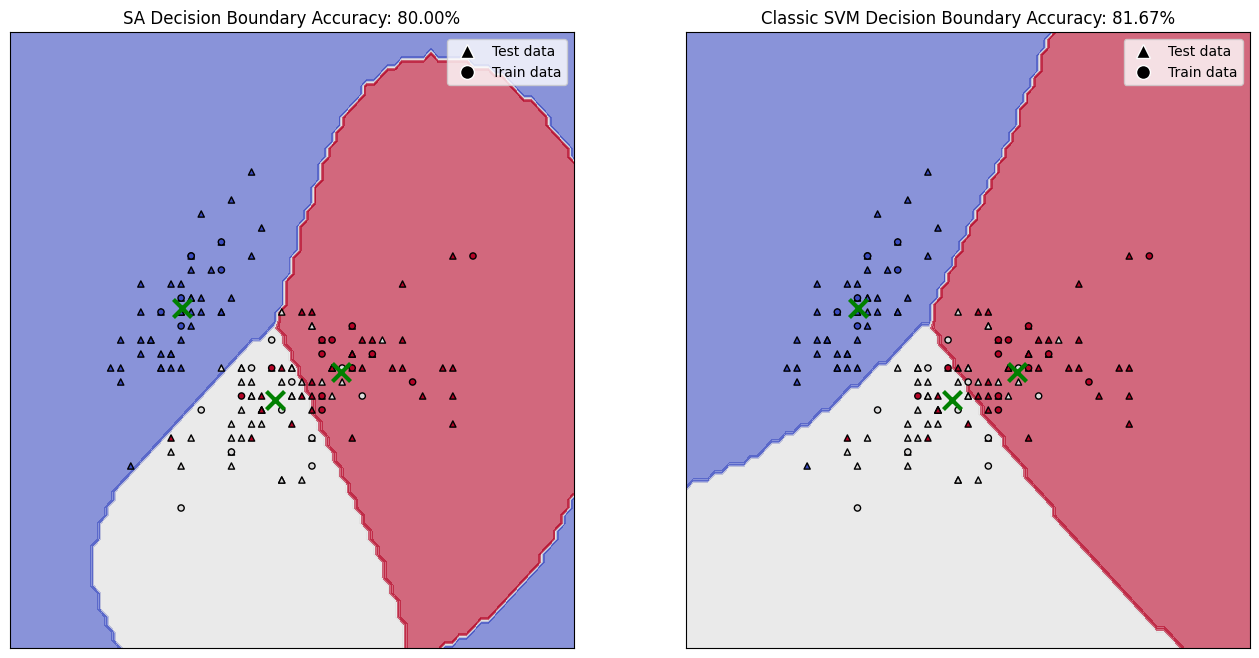

In [53]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))

# Create meshgrid
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)
# cm = plt.cm.coolwarm
# cm = plt.cm.Paired

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, sa_one_vs_rest, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"SA Decision Boundary Accuracy: {sa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, svm_classifier, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"Classic SVM Decision Boundary Accuracy: {svm_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_petal_SA_Classic.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("Classic SVM onfusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.savefig("results\iris_classic_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = sa_one_vs_rest.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("SA Confusion Matrix")

plt.savefig("results\iris_sa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [55]:
from qsvm import *

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "QA",
    "vis" : 0
}

# Initialize and train the classifier
qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
qa_OvR.solve(X_train, y_train)

# Evaluate the classifier
qa_accuracy = qa_OvR.evaluate(X_test, y_test)
print(f"Test Accuracy: {qa_accuracy*100:.2f}%")

Training classifier 0...
solving...
K,N 2 30
self.intercept 0.40287434705316344
Training classifier 1...
solving...
K,N 2 30
self.intercept -2.3840072305403646
Training classifier 2...
solving...
K,N 2 30
self.intercept -1.9374747302560473
pred result [0 0 0 2 2 1 1 1 1 0 2 0 0 2 1 2 1 1 0 1 1 0 1 2 1 1 1 1 0 0 2 1 2 1 2 1 2
 1 1 2 0 0 0 2 1 0 2 1 0 1 1 0 1 0 1 2 1 0 0 1 0 2 2 2 0 0 1 0 1 2 2 2 2 2
 0 0 0 2 0 0 0 2 0 0 1 1 0 0 2 2 1 0 1 2 0 0 1 2 0 1 0 1 2 0 2 2 2 2 0 2 0
 1 2 0 1 0 2 1 2 0]
Test Accuracy: 80.00%


self.intercept 30.233025042260856
self.intercept 17.65511144643791
self.intercept -0.05865579487929519


C:\Users\happy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook.py:1087: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


pred result [0 0 0 2 2 2 1 1 2 0 2 0 0 2 2 2 0 1 0 2 1 0 1 2 2 0 0 1 0 0 2 1 2 1 2 1 2
 2 1 2 0 0 0 2 0 0 2 1 0 0 1 0 1 0 0 2 1 0 0 2 0 2 2 2 0 0 2 0 1 2 2 2 2 2
 0 0 0 2 0 0 0 2 0 0 2 2 0 0 2 2 1 0 1 2 0 0 1 2 0 2 0 0 2 0 2 2 2 2 0 2 0
 1 2 0 1 0 2 2 2 0]
Test Accuracy: 75.00%


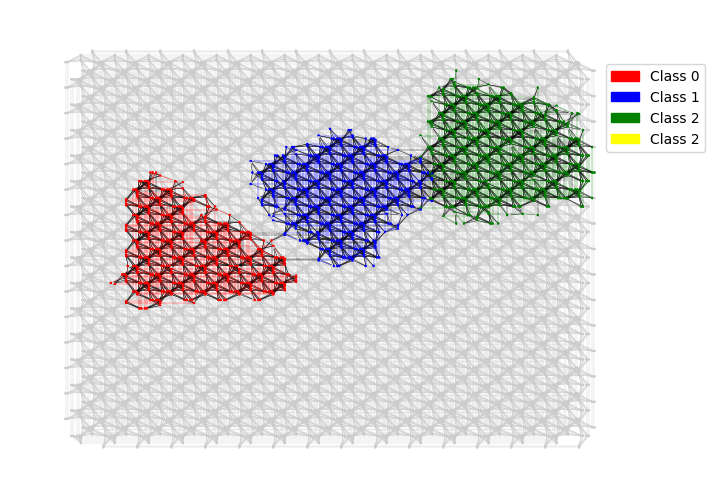

In [57]:
from qsvm import *

gamma = 0.2
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "MTQA",
    "vis": 1
}

# Initialize and train the classifier
mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
mtqa_OvR.solve(X_train, y_train)

# Evaluate the classifier
mtqa_accuracy = mtqa_OvR.evaluate(X_test, y_test)
print(f"Test Accuracy: {mtqa_accuracy*100:.2f}%")

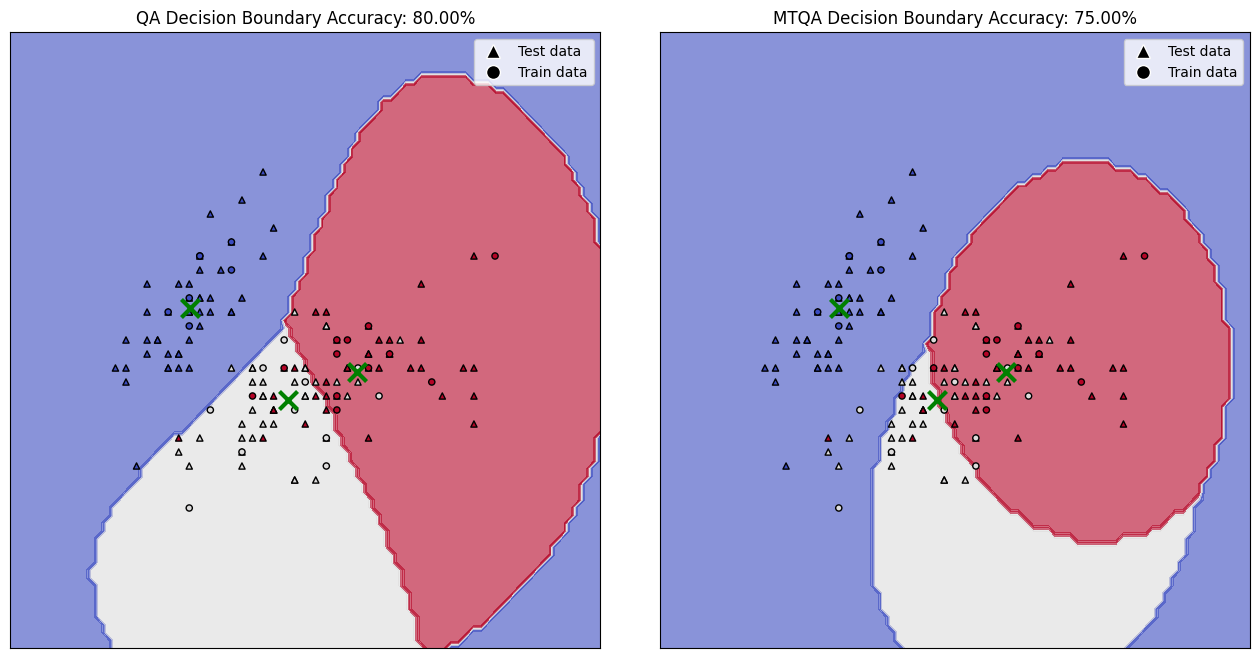

In [58]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Create meshgrid
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, qa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"QA Decision Boundary Accuracy: {qa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, mtqa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"MTQA Decision Boundary Accuracy: {mtqa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_petal_QA_MTQA.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = mtqa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("MTQA Confusion Matrix")

plt.savefig("results\iris_mtqa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = qa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("QA Confusion Matrix")

plt.savefig("results\digit_0_3_qa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()
